# CAB420 Assignment 1B Question 1: Template and Utilities Demo

## Overview

This notebook provides a quick demo and overview of the provided utility functions to help with Assignment 1B, Question 1.

## Utility Functions

The following cell contains utility functions to:
* Load the data
* Vectorise the data
* Plot images
* Resize all images
* Convert images to grayscale
* Build pairs or triplets of images for metric learning networks
* Plot a CMC Curve

These are provided to assist you in developing your solution.

In [1]:
#
# Utility functions for CAB420, Assignment 1B, Q1
# Author: Simon Denman (s.denman@qut.edu.au)
#
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import os
import glob
import random

# get the subject ID from the filename. A sample filename is 0001_c1s1_001051_00.jpg, the first
# four characters are the subject ID
#   fn:      the filename to parse
# 
#   returns: first four characters of the filename converted to an int
#
def get_subject_id_from_filename(fn):
    return int(fn[0:4])

# load the images in a directory
#   base_path: path to the data
#
#   returns:   numpy arrays of size (samples, width, height, channels), and size (samples) for 
#              images and thier labels
def load_directory(base_path):

    # find all images in the directory
    files = glob.glob(os.path.join(base_path, '*.jpg'))
    x = []
    y = []
    
    # loop through the images, loading them and extracting the subject ID
    for f in files:
        x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
        y.append(get_subject_id_from_filename(os.path.basename(f)))
        
    return np.array(x), np.array(y)

# load the data
#   base_path: path to the data, within the directory that this points to there should be a 'Training' 
#              and 'Testing' directory
#
#   returns:   loaded data
#
def load_data(base_path):
    
    # load training data
    train_X, train_Y = load_directory(os.path.join(base_path, 'Training'))

    # load gallery data from the test set
    gallery_X, gallery_Y = load_directory(os.path.join(base_path, 'Testing', 'Gallery'))

    # load probe data from the test set
    probe_X, probe_Y = load_directory(os.path.join(base_path, 'Testing', 'Probe'))
    
    return train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y

# Plot some images and their labels. Will plot the first 50 samples in a 10x5 grid
#  x: array of images, of shape (samples, width, height, channels)
#  y: labels of the images
#
def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(y[i])
        ax.axis('off')
        
# vectorise an array of images, such that the shape is changed from {samples, width, height, channels} to
# (samples, width * height * channels)
#   images: array of images to vectorise
#
#   returns: vectorised array of images
#
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

# Resize an array of images
#  images:   array of images, of shape (samples, width, height, channels)
#  new_size: tuple of the new size, (new_width, new_height)
#
#  returns:  resized array of images, (samples, new_width, new_height, channels)
#
def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()
          
# Convert images to grayscale
#   images:  array of colour images to convert, of size (samples, width, height, 3)
#
#   returns: array of converted images, of size (samples, width, height, 1)
#
def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

# Create a batch of siamese data. Pairs will be evenly balanced, such that there is an
# equal number of positive and negative pairs
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   returns:    image pairs and labels to indicate if the pairs are the same, or different
#
def get_siamese_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

# Generator to continually produce batches of Siamese Data
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   yields:     image pairs and labels to indicate if the pairs are the same, or different
#
def pair_generator(imgs, labels, batch_size):
    while True:
        [image_a, image_b], label = get_siamese_data(imgs, labels, batch_size)
        yield [image_a, image_b], label
        
# Plot the first 10 pairs of a batch, good sanity check for pair generation
#  x: images in the pairs
#  y: labels of the pairs
#
def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(10):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
        
# Create a batch of triplet data.
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of triplets to generate 
#
#   returns:    triplet of the requested batch size
#
def get_triplet_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

# Generator to continually produce batches of Triplet Data
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   yields:     triplet of the requested batch size
#
def triplet_generator(imgs, labels, batch_size):
    while True:
        [image_a, image_b, image_c] = get_triplet_data(imgs, labels, batch_size)
        yield [image_a, image_b, image_c], None


# Plot the first 9 triplets of a batch, good sanity check for triplet generation
#  x: images in the triplets
#
def plot_triplets(x):
    fig = plt.figure(figsize=[25, 10])
    for i in range(9):
        ax = fig.add_subplot(3, 9, i*3 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Anchor')

        ax = fig.add_subplot(3, 9, i*3 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Positive')

        ax = fig.add_subplot(3, 9, i*3 + 3)
        ax.imshow(x[2][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Negative')

        
# Compute a ranked histogram, which can be used to generate a CMC curve. This function will loop 
# through all probe samples. For each probe sample it will:
#  - Compare the sample to all gallery samples to get a distance between the probe sample and 
#    all gallery samples. In this case it is the L1 distance
#  - Sort the gallery samples by how close they are to the probe samples
#  - Find the location of the true match
#  - Update a ranked histogram based on this
# The ranked histogram will show how many samples are matched at each rank. For example,
# ranked_histogram[0] will record how many samples are matched at Rank-1. 
#
# This implementation assumes that there is only one sample per ID in the gallery set
#
# NOTE: L1 distance, used here, may not be appropriate for all problems. Consider the nature
# of your problem and what distance measure you should use
#
#   gallery_feat: features for the gallery data, of shape (gallery_samples, num_features)
#   gallery_Y:    IDs of the gallery samples, of shape (gallery_samples,)
#   probe_feat:   features for the probe data, of shape (probe_samples, num_features)
#   probe_Y:      IDs of the probe samples, of shape (probe_samples,)
#   verbose:      bool to indicate if debug information shoudl be printed. Be careful using this with 
#                 large feature sets, and/or lots of samples
#   
#   returns:      ranked histogram matching the probe samples to the gallery
#
def get_ranked_histogram_l1_distance(gallery_feat, gallery_Y, probe_feat, probe_Y, verbose = False):
    
    # storage for ranked histogram
    # length equal to number of unique subjects in the gallery
    ranked_histogram = np.zeros(len(np.unique(gallery_Y)))

    # loop over all samples in the probe set
    for i in range(len(probe_Y)):
        # get the true ID of this sample
        true_ID = probe_Y[i]
        if verbose:
            print('Searching for ID %d' % (true_ID))

        # get the distance between the current probe and the whole gallery, L1 distance here. Note that L1
        # may not always be the best choice, so consider your distance metric given your problem
        dist = np.linalg.norm(gallery_feat - probe_feat[i,:], axis=1, ord=1)
        if verbose:
            print(dist)

        # get the sorted order of the distances
        a = np.argsort(dist)
        # apply the order to the gallery IDs, such that the first ID in the list is the closest, the second
        # ID is the second closest, and so on
        ranked = gallery_Y[a]
        if verbose:
            print('Ranked IDs for query:')
            print(a)

        # find the location of the True Match in the ranked list
        ranked_result = np.where(ranked == true_ID)[0][0]
        if verbose:
            print(ranked_result)

        # store the ranking result in the histogram
        ranked_histogram[ranked_result] += 1
        if verbose:
            print('')
    
    if verbose:
        print(ranked_histogram)
    
    return ranked_histogram

# Convert a ranked histogram to a CMC. This simply involves computing the cumulative sum over the histogram
# and dividing it by the length of the histogram
#   ranked_hist: ranked histogram to convert to a CMC
#
#   returns:     CMC curve
#
def ranked_hist_to_CMC(ranked_hist):

    cmc = np.zeros(len(ranked_hist))
    for i in range(len(ranked_hist)):
        cmc[i] = np.sum(ranked_hist[:(i + 1)])
    
    return (cmc / len(ranked_hist))

# plot a CMC
#   cmc: cmc data to plot
#
def plot_cmc(cmc):
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(1, len(cmc)+1), cmc)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_ylim([0, 1.0])
    ax.set_title('CMC Curve')      

## Utility Function Demonstration

The following presents a brief demonstration of the utility functions. These portions of code do not form part of the template, or solution, and could be commented out/removed, or you could restructure this portion of the code to form part of your solution.

### Data Loading

This will load the data, pulling out the training set, and gallery and probe testing sets.

(5933, 128, 64, 3)
(5933,)
(301, 128, 64, 3)
(301,)
(301, 128, 64, 3)
(301,)
[1200 1201 1202 1203 1204 1205 1206 1207 1208 1209 1210 1211 1212 1213
 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223 1224 1225 1226 1227
 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237 1238 1239 1240 1241
 1242 1243 1244 1245 1246 1247 1248 1249 1250 1251 1252 1253 1254 1255
 1256 1257 1258 1259 1260 1261 1262 1263 1264 1265 1266 1267 1268 1269
 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1280 1281 1282 1283
 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294 1295 1296 1297
 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309 1310 1311
 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323 1324 1325
 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337 1338 1339
 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351 1352 1353
 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365 1366 1367
 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379 1380 1381


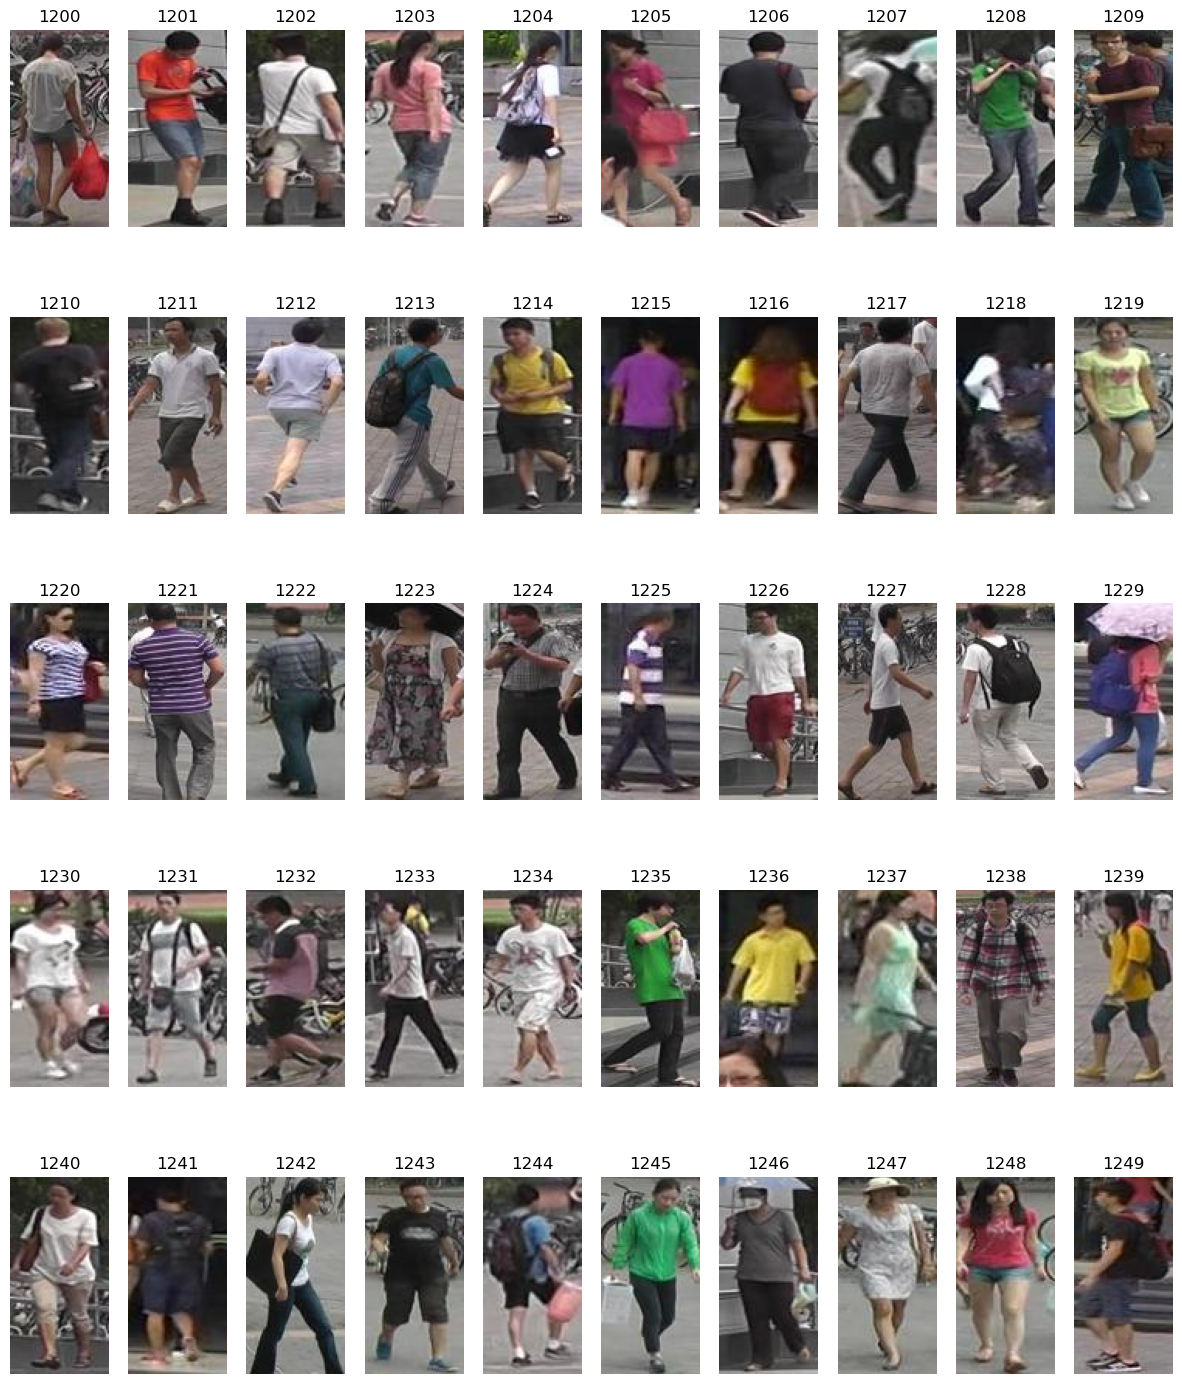

In [2]:
# note that you will probably need to change the filepath here
train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('Q1')
print(train_X.shape)
print(train_Y.shape)
print(gallery_X.shape)
print(gallery_Y.shape)
print(probe_X.shape)
print(probe_Y.shape)

# plot some images
plot_images(gallery_X, gallery_Y)
print(gallery_Y)

### Pair and Triplet Data

Pair and triplet functions are provided to pull out paired and triplet data for use with Siamese networks.

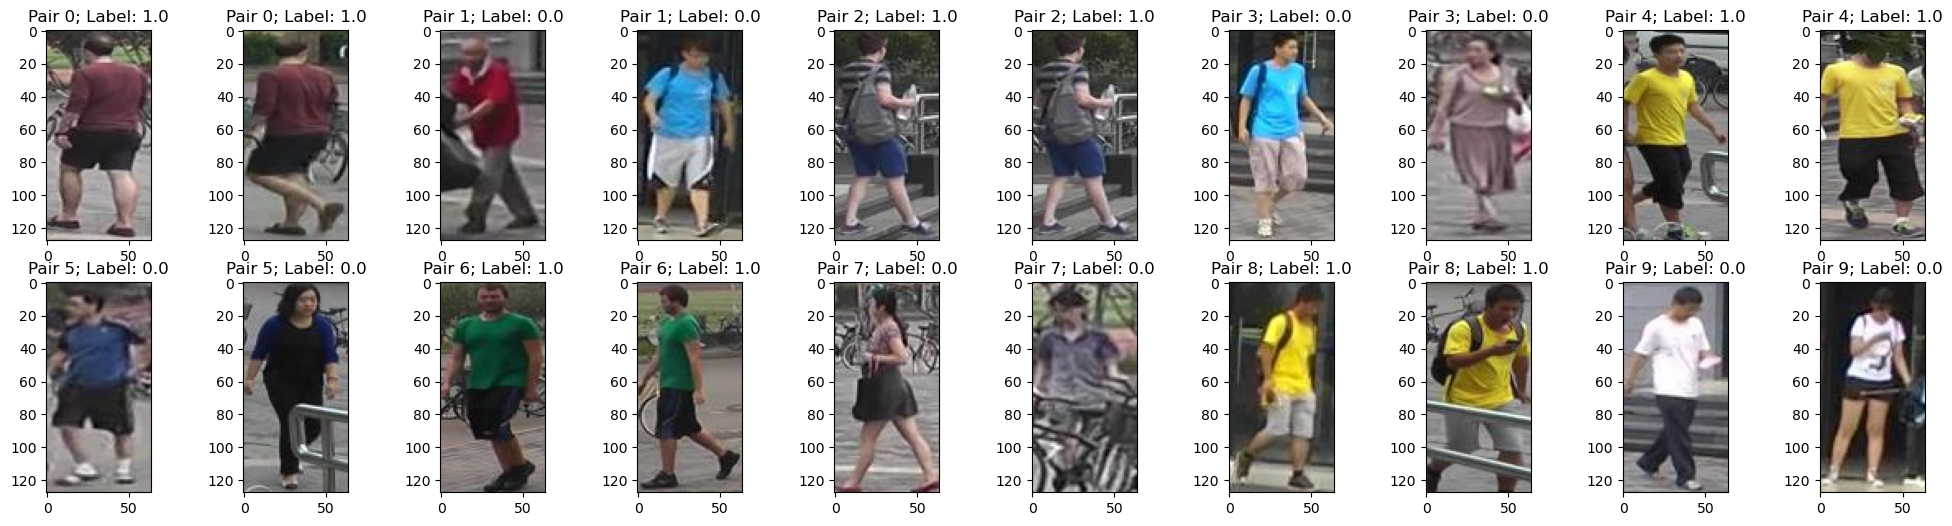

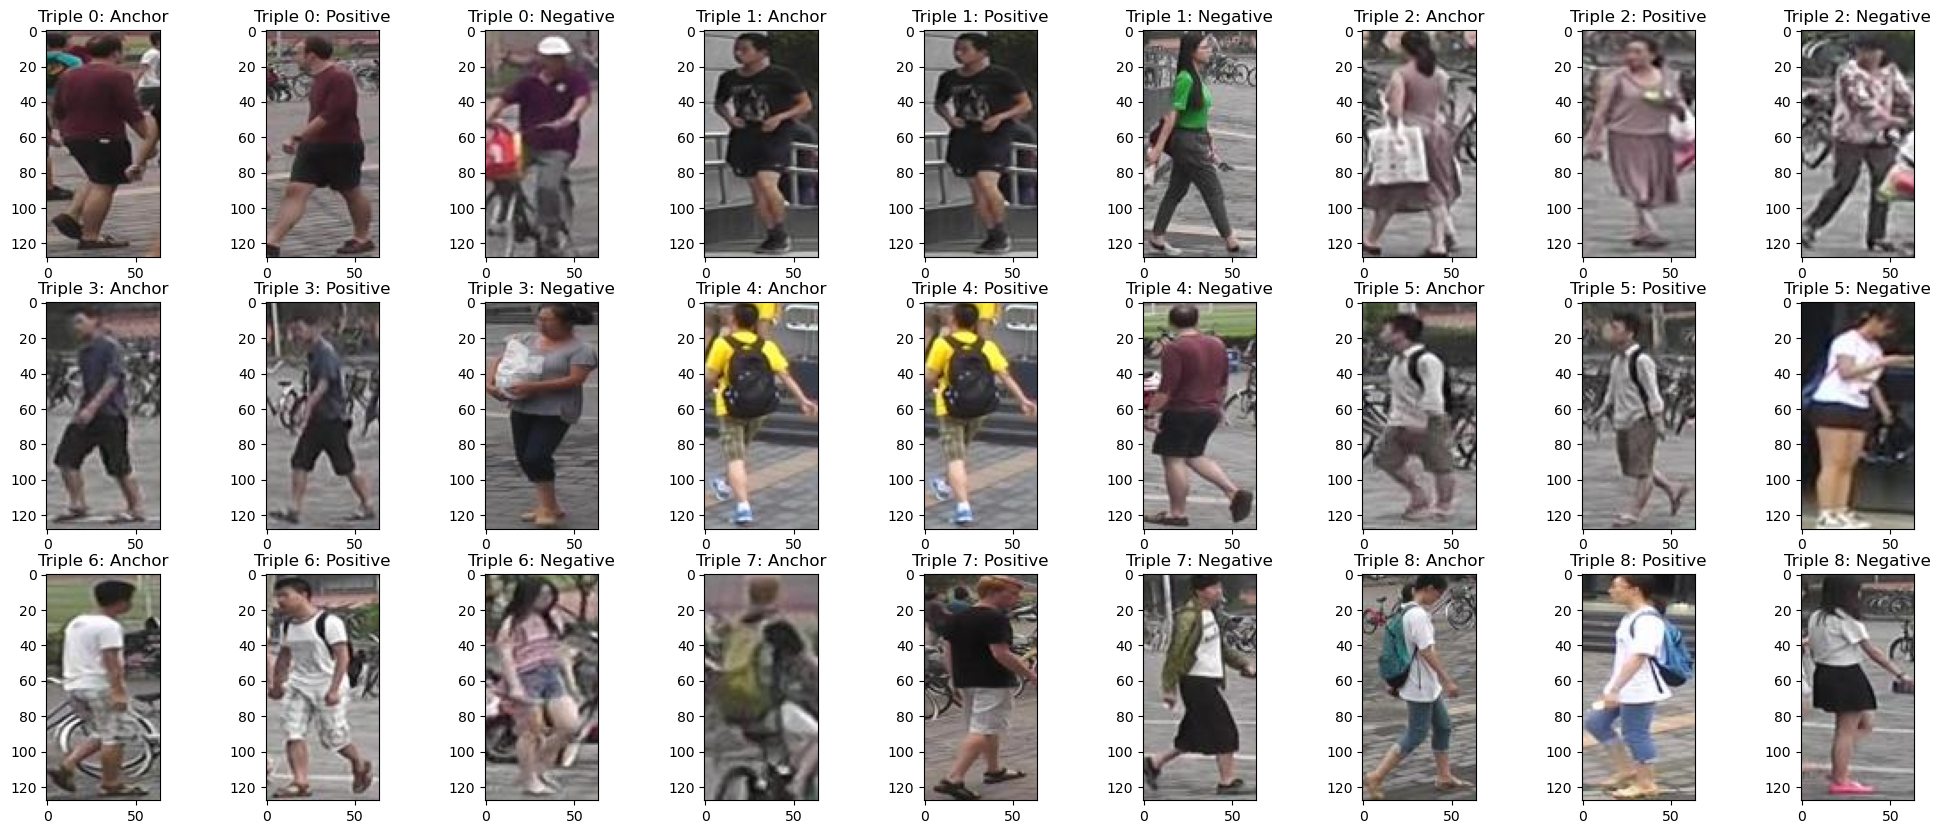

In [3]:
# create a pair generator and display a pair
pair_test = pair_generator(train_X, train_Y, 10)
x, y = next(pair_test)
plot_pairs(x, y)

# create a triplet and display a triplet
triplet_test = triplet_generator(train_X, train_Y, 9)
x, _ = next(triplet_test)
plot_triplets(x)

### Conversion and Resizing

Functions to convert images to greyscale and resize them are also provided.

(301, 64, 32, 1)
(301, 64, 32, 1)


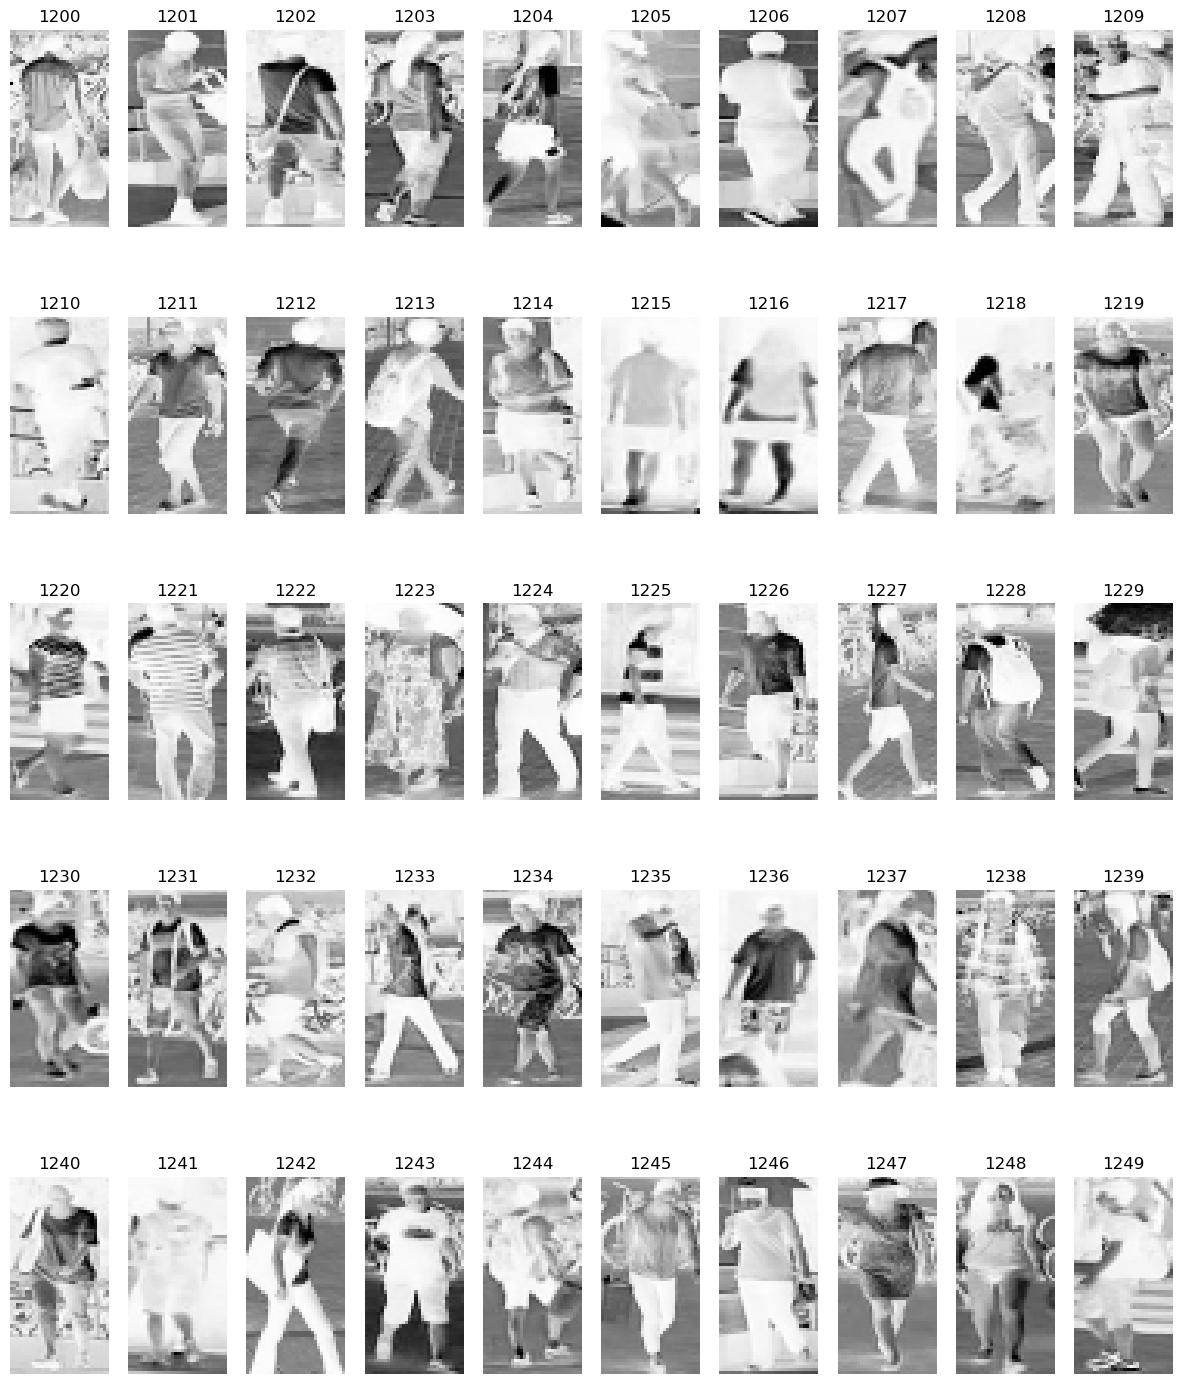

In [4]:
# resize data and convert to grayscale
gallery_X_small_gray = convert_to_grayscale(resize(gallery_X, (64, 32)))
print(gallery_X_small_gray.shape)
probe_X_small_gray = convert_to_grayscale(resize(probe_X, (64, 32)))
print(probe_X_small_gray.shape)

# plot some resized and grayscale images
plot_images(gallery_X_small_gray, gallery_Y)

### CMC Curves

Functions to create a CMC curve are provided. These assume that you have data in the following form:
* An array of gallery features, of size (gallery_samples, num_features)
* An array of gallery IDs, of size (gallery_samples)
* An array of probe features, of size (probe_samples, num_features)
* An array of probe IDs, of size (probe_samples)

Note that the provided implementation is limited in that it assumes that you have only one sample from each gallery ID in the set of gallery samples.

The process of generating a CMC is split across three functions:
* ``get_ranked_histogram_l1_distance``, which will compare each probe sample to all gallery samples and determine the location of the correct match (the rank), storing this in a histogram
* ``ranked_hist_to_CMC``, which will convert the ranked histogram to a CMC
* ``plot_cmc``, which will actually plot the CMC

Two simple examples demonstrating this are given below.

[0 1 2 3 4 5 6 7]
[[ 1.17152235 -0.9137541 ]
 [-0.35377515  1.39957573]
 [ 0.60825862  2.00068471]
 [ 1.14770002  1.69779522]
 [ 3.140268    3.52753998]
 [ 4.13550541  5.30752642]
 [ 4.12637447  7.36574995]
 [ 6.03389056  6.19766541]]
(8, 2)
[0 1 2 3 4 5 6 7]
[[ 1.61723392  1.68670349]
 [-2.6426211   4.46737663]
 [ 3.41202809 -0.14317751]
 [ 4.10339759  2.08852827]
 [ 4.88117112  6.76916489]
 [ 1.170848    5.64901247]
 [ 9.77177008  6.33432847]
 [ 3.67542608  8.86124968]]
(8, 2)
Searching for ID 0
[3.04616917 2.25813684 1.32295652 0.48062563 3.36387056 6.13909441
 8.18818701 8.92761856]
Ranked IDs for query:
[3 2 1 0 4 5 6 7]
3

Searching for ID 1
[ 9.19527418  5.35664685  5.71757164  6.55990253  6.72272575  7.6182763
  9.6673689  10.40680045]
Ranked IDs for query:
[1 2 3 4 5 0 6 7]
0

Searching for ID 2
[3.01108233 5.30855648 4.94763169 4.10530079 3.94247758 6.17418124
 8.22327384 8.9627054 ]
Ranked IDs for query:
[0 4 3 2 1 5 6 7]
3

Searching for ID 3
[5.93415761 5.14612528 3.582982

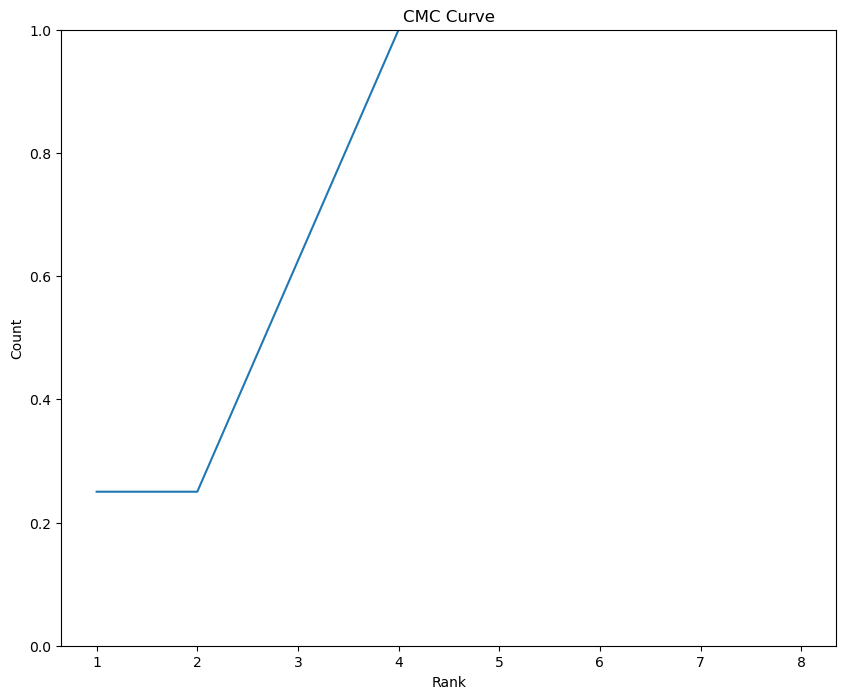

In [5]:
# we'll start off with just 8 IDs
num_ids = 8

# we'll create a list of IDs, these are the gallery and probe IDs (gallery_y and probe_y)
ID_1 = np.arange(0, num_ids, 1)
ID_2 = np.arange(0, num_ids, 1)
# we'll then generate some features
# to keep this simple, we'll use a 2D feature, i.e. each sample will have a 2D feature associated with it
# this means that we have our gallery features of size (8, 2), as we have 8 samples and 2D feaures
Feat_1 = np.transpose(np.vstack([ID_1, ID_1]) + (np.random.rand(2, num_ids) - 0.5)*4.0, (1,0))
Feat_2 = np.transpose(np.vstack([ID_2, ID_2]) + (np.random.rand(2, num_ids) - 0.5)*8.0, (1,0))

# print features and their shape to confirm what we have
print(ID_1)
print(Feat_1)
print(Feat_1.shape)
print(ID_2)
print(Feat_2)
print(Feat_2.shape)

# we can now compute the ranked histogram
# this will print out of a heap of debug data to show what's going on. In particular we see the distance between
# each probe sample and the whole gallery, and the rank of the true match, which is what is used to build the 
# ranked histogram
ranked_hist = get_ranked_histogram_l1_distance(Feat_1, ID_1, Feat_2, ID_2, True)
print(ranked_hist)
cmc = ranked_hist_to_CMC(ranked_hist)
print(cmc)
plot_cmc(cmc)

The above example results in a pretty simple CMC. Let's throw more IDs at it to get something that looks a bit better. The setup here is the same as what's above, we just have 100 gallery and probe samples now instead.

(100, 2)
(100, 2)


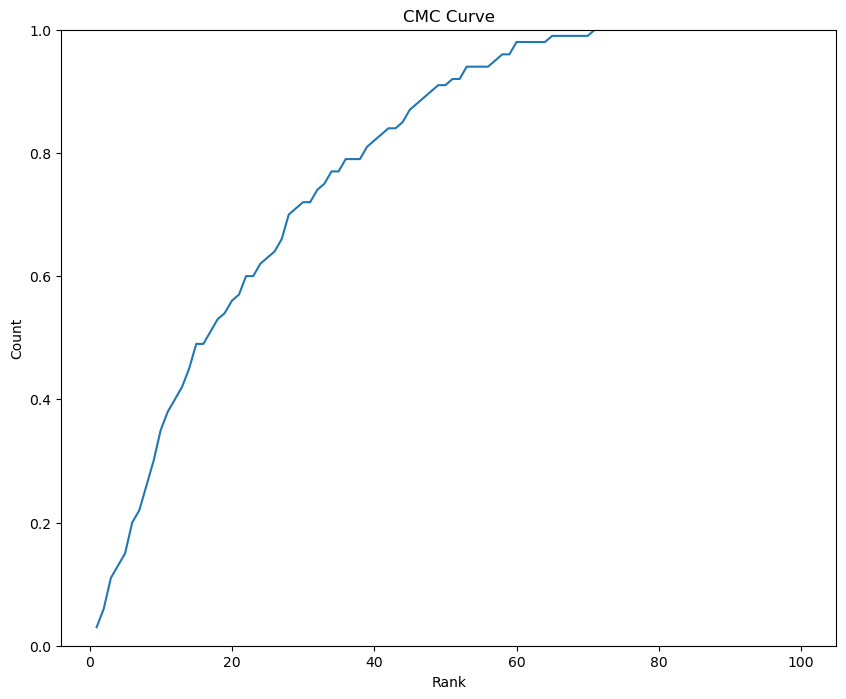

In [6]:
num_ids = 100

ID_1 = np.arange(0, num_ids, 1)
ID_2 = np.arange(0, num_ids, 1)
Feat_1 = np.transpose(np.vstack([ID_1, ID_1]) + (np.random.rand(2, num_ids) - 0.5)*20.0, (1,0))
Feat_2 = np.transpose(np.vstack([ID_2, ID_2]) + (np.random.rand(2, num_ids) - 0.5)*80.0, (1,0))
print(Feat_1.shape)
print(Feat_2.shape)

ranked_hist = get_ranked_histogram_l1_distance(Feat_1, ID_1, Feat_2, ID_2)
cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(cmc)

With a CMC, the ideal curve is one that is always at 100%. The steeper the curve and faster it get's to 100%, the better.

### Vectorising Data

To use the images with non-DL methods, they need to be vectorised. A function is provided for this.

In [7]:
# vectorise some data
gallery_feat = vectorise(gallery_X_small_gray)
probe_feat = vectorise(probe_X_small_gray)
print(gallery_feat.shape)
print(probe_feat.shape)

#
# at this point, you have data in the shape (gallery_samples, number_of_features) and (probe_samples, number_of_features)
# and you could compare these two sets of features
#
# using colour data alone is a poor feature choice, but nonetheless you could do this.

(301, 2048)
(301, 2048)


### Deep Learning Solution

In [8]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import random
import numpy
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# for consistency
random.seed(4)

In [9]:
class TrainForTime(keras.callbacks.Callback):
    def __init__(
        self,
        train_time_mins=5,
    ):
        super().__init__()

        self.train_time_mins = train_time_mins
        self.epochs = 0
        self.train_time = 0
        self.end_early = False

    def on_train_begin(self, logs=None):
        # save the start time
        self.start_time = tf.timestamp()

    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        current_time = tf.timestamp()
        training_time = (current_time - self.start_time)
        if (training_time / 60) > self.train_time_mins:
            self.train_time = current_time - self.start_time
            self.model.stop_training = True
            self.end_early = True


    def on_train_end(self, logs=None):
        if self.end_early:
            print('training time exceeded and ending early')
            print(f'training ended on epoch {self.epochs}')
            print(f'training time = {self.train_time / 60} mins')

In [10]:
train_X_small_gray = convert_to_grayscale(resize(train_X, (64, 32)))

In [11]:
train_fea = train_X_small_gray
train_gnd = train_Y
gallery_fea = gallery_X_small_gray
gallery_gnd = gallery_Y

print(gallery_gnd)
print(numpy.shape(train_fea))
print(numpy.shape(train_gnd))
print(numpy.shape(gallery_fea))
print(numpy.shape(gallery_gnd))

[1200 1201 1202 1203 1204 1205 1206 1207 1208 1209 1210 1211 1212 1213
 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223 1224 1225 1226 1227
 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237 1238 1239 1240 1241
 1242 1243 1244 1245 1246 1247 1248 1249 1250 1251 1252 1253 1254 1255
 1256 1257 1258 1259 1260 1261 1262 1263 1264 1265 1266 1267 1268 1269
 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1280 1281 1282 1283
 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294 1295 1296 1297
 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309 1310 1311
 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323 1324 1325
 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337 1338 1339
 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351 1352 1353
 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365 1366 1367
 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379 1380 1381
 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393 1394 1395
 1396 

In [12]:
probe_fea = probe_X_small_gray
probe_gnd = probe_Y

In [13]:
train_fea_reshape = numpy.reshape(train_fea, (len(train_fea), 64, 32, 1))
gallery_fea_reshape = numpy.reshape(gallery_fea, (len(gallery_fea), 64, 32, 1))
probe_fea_reshape = numpy.reshape(probe_fea, (len(probe_fea), 64, 32, 1))
print(train_fea_reshape.shape)
print(gallery_fea_reshape.shape)
print(probe_fea_reshape.shape)

(5933, 64, 32, 1)
(301, 64, 32, 1)
(301, 64, 32, 1)


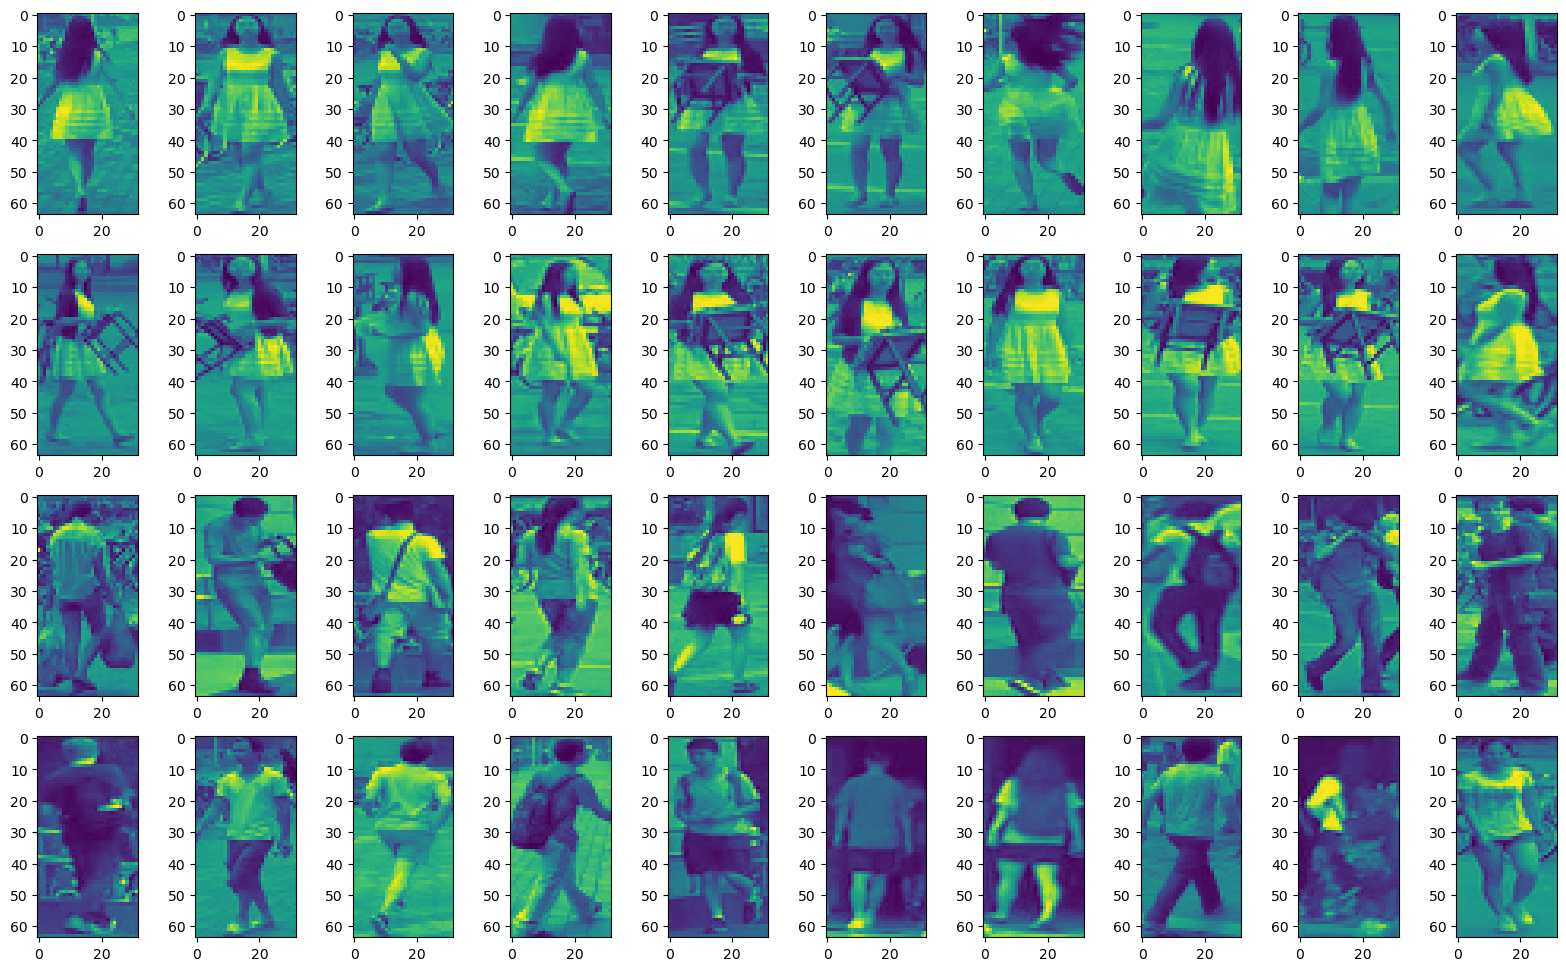

In [14]:
fig = plt.figure(figsize=[20, 12])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(gallery_fea_reshape[i,:,:,0])   

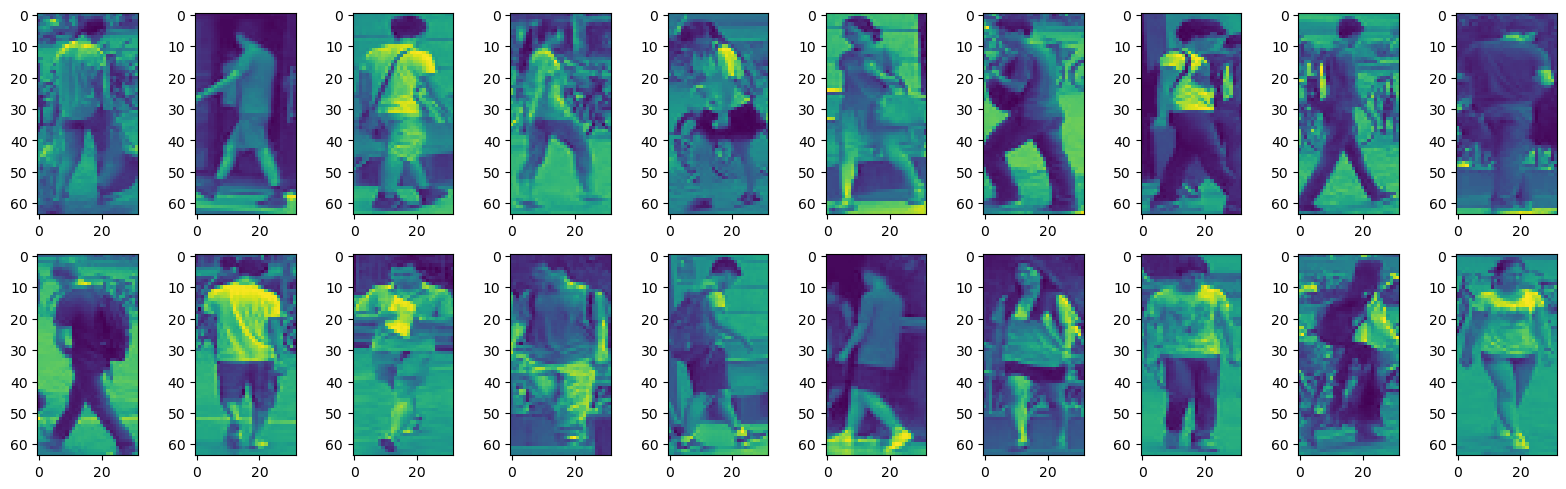

In [15]:
fig = plt.figure(figsize=[20, 12])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(probe_fea_reshape[i,:,:,0])   

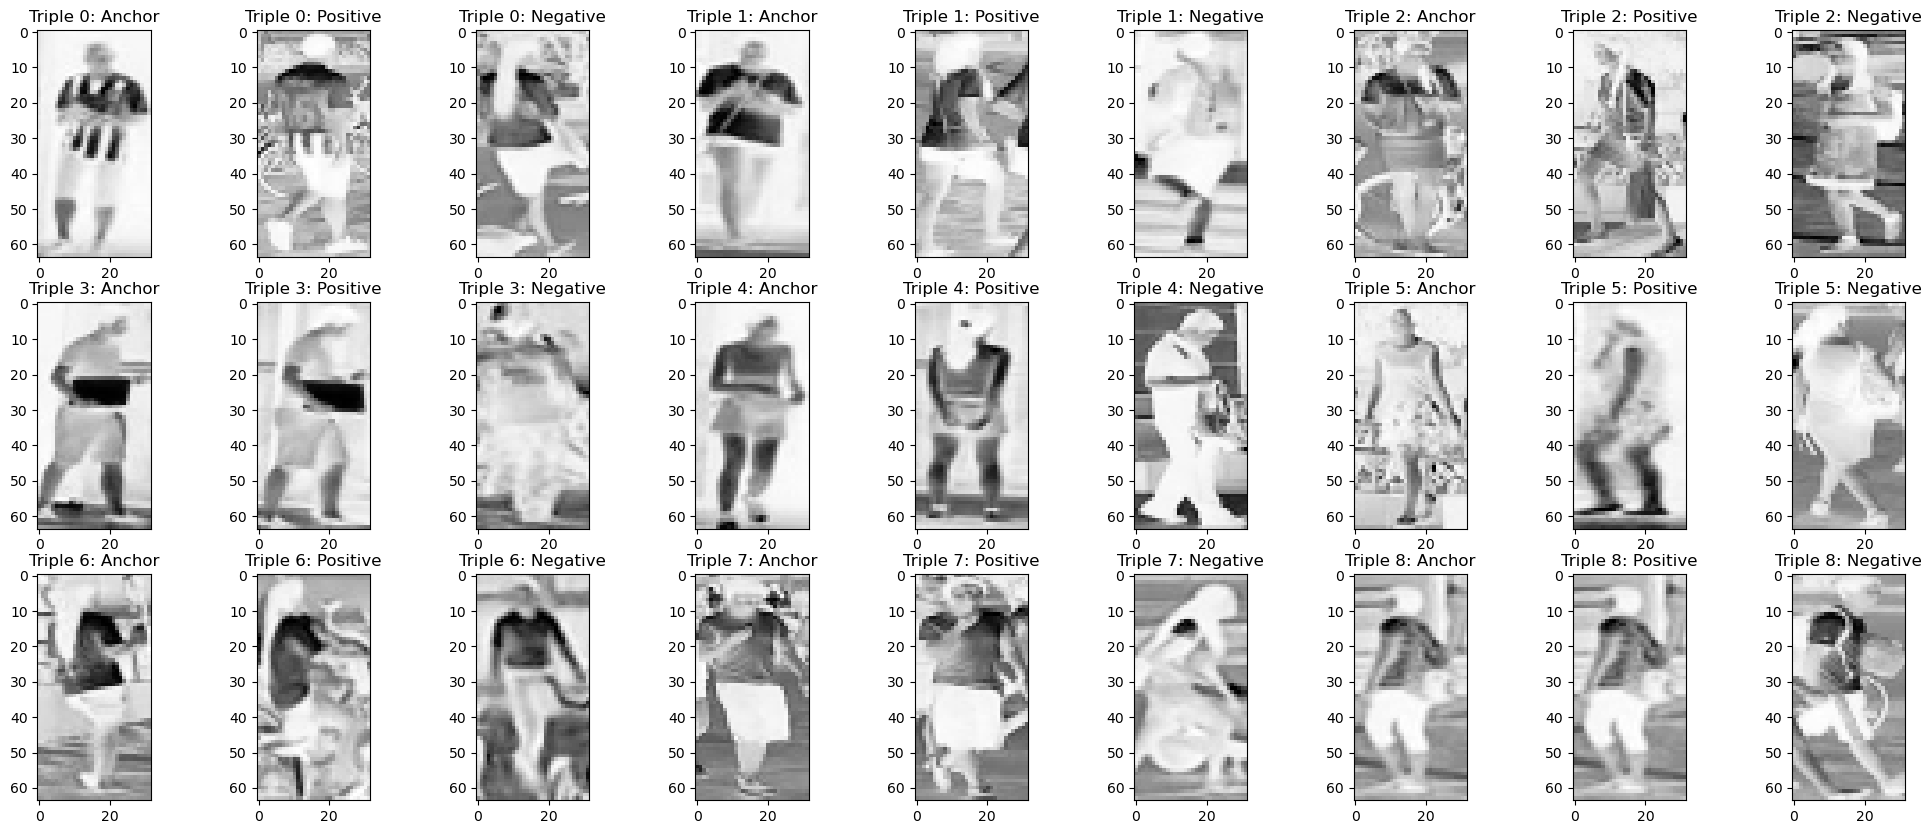

In [16]:
triplet_test = triplet_generator(train_fea_reshape, train_gnd, 9)
x, _ = next(triplet_test)
plot_triplets(x)

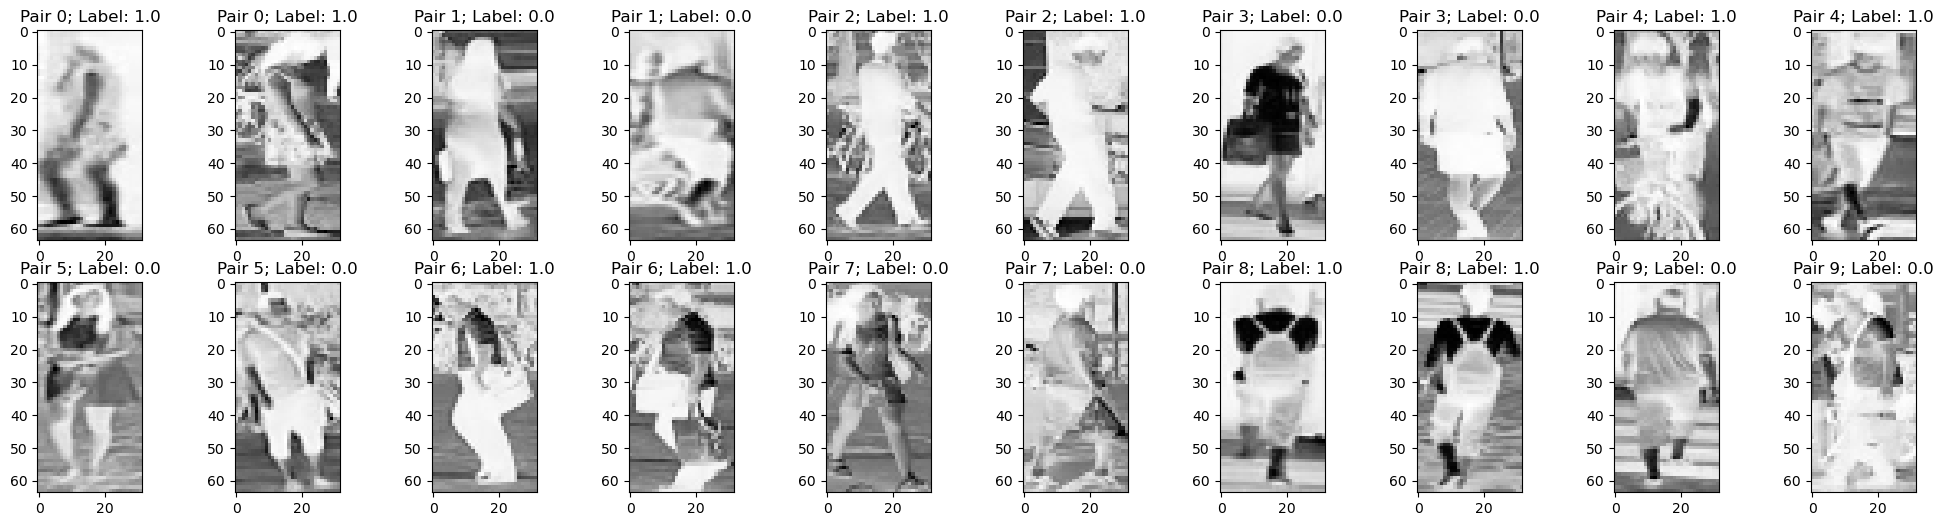

In [17]:
pair_test = pair_generator(train_fea_reshape, train_gnd, 10)
x, y = next(pair_test)
plot_pairs(x, y)

In [18]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [19]:
embedding_size = 32
dummy_input = keras.Input((64, 32, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = K.l2_normalize(anchor, axis=1)
        positive = K.l2_normalize(positive, axis=1)
        negative = K.l2_normalize(negative, axis=1)

        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
input_anchor = keras.Input((64, 32, 1), name='Anchor')
input_positive = keras.Input((64, 32, 1), name='Positive')
input_negative = keras.Input((64, 32, 1), name='Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([embedding_anchor, embedding_positive, embedding_negative])

In [20]:
triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
triplet_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor (InputLayer)            [(None, 64, 32, 1)]  0           []                               
                                                                                                  
 Positive (InputLayer)          [(None, 64, 32, 1)]  0           []                               
                                                                                                  
 Negative (InputLayer)          [(None, 64, 32, 1)]  0           []                               
                                                                                                  
 SiameseBranch (Functional)     (None, 32)           1076344     ['Anchor[0][0]',                 
                                                                  'Positive[0][0]',           

In [21]:
import tensorflow as tf

triplet_network.compile(optimizer=keras.optimizers.RMSprop(), metrics= [tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

batch_size = 256
training_gen = triplet_generator(train_fea_reshape, train_gnd, batch_size)
triplet_test_x = get_triplet_data(gallery_fea_reshape, gallery_gnd, 1000)

triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=5, validation_data=(triplet_test_x, None))

Epoch 1/5
234/234 [==============================] - 129s 540ms/step - loss: 79.6411 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 1.6400 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/5
234/234 [==============================] - 128s 545ms/step - loss: 46.7066 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 1.1992 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 3/5
234/234 [==============================] - 128s 546ms/step - loss: 36.0554 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 1.0373 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 4/5
234/234 [==============================] - 131s 560ms/step - loss: 29.1867 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 0.8368 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 5/5
234/234 [==============================] - 126s 538ms/step - loss: 25.2978 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 0.6933 - val_top_k_categorical_accuracy: 0.0000e+00


186/186 [==============================] - 2s 11ms/step


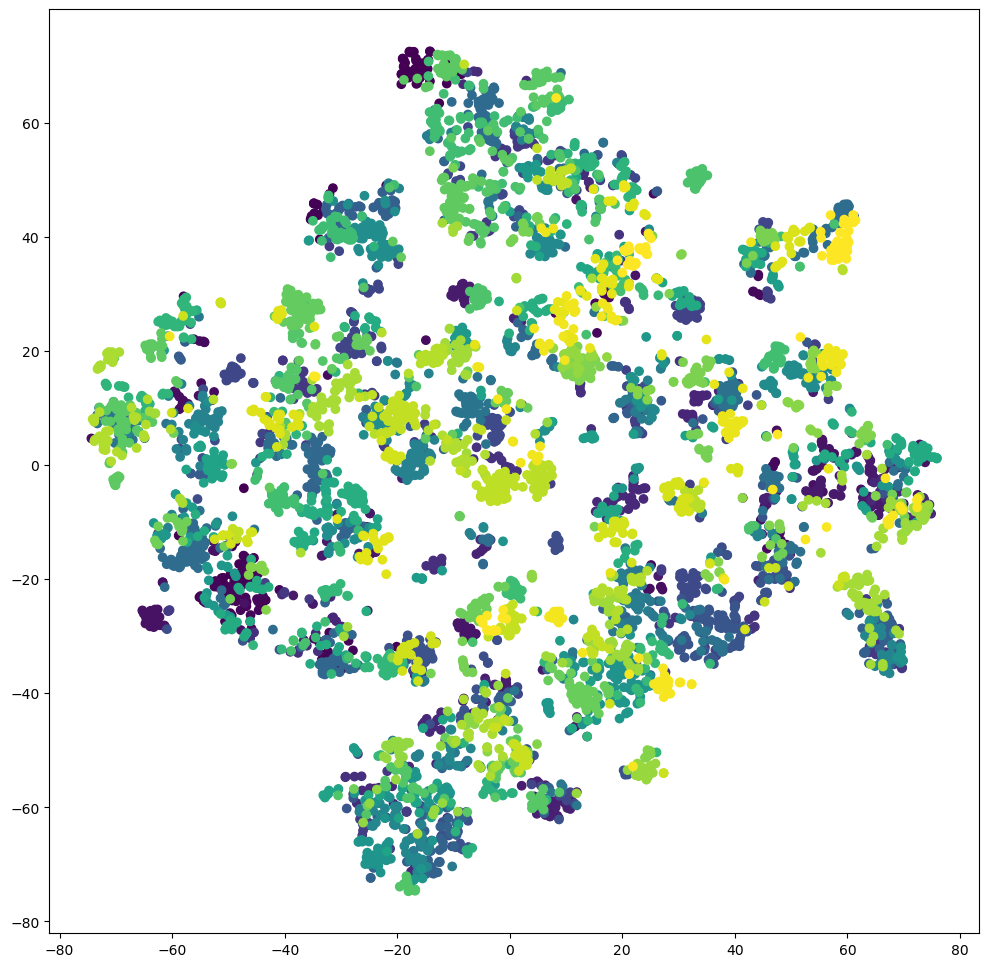

In [22]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_gnd.flatten());

10/10 [==============================] - 0s 11ms/step


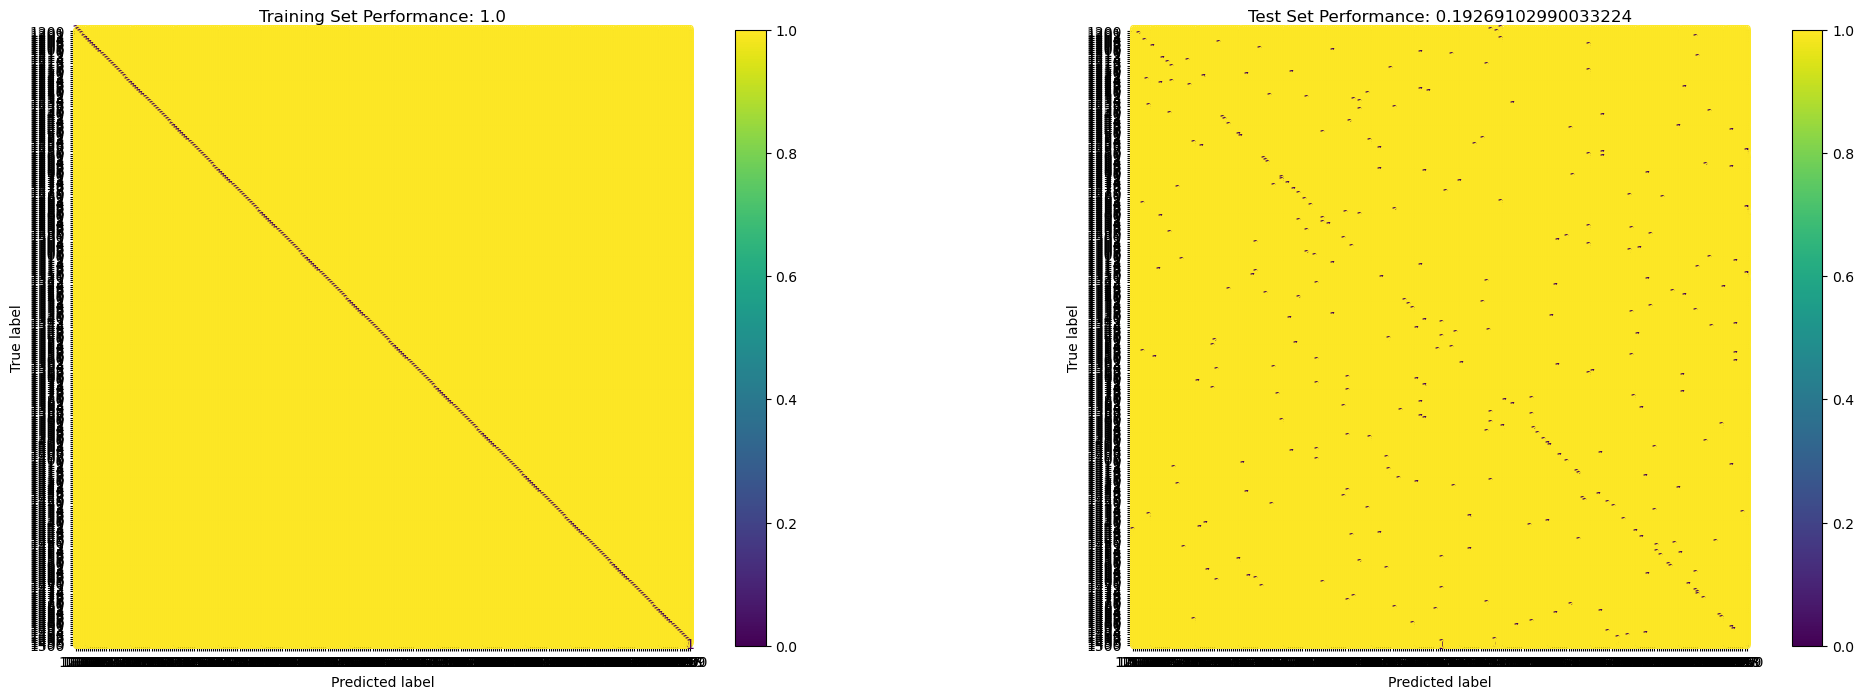

In [23]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: %s' % (sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: %s' % (sum(pred == Y_test)/len(Y_test)));    

gallery_embeddings = base_network.predict(gallery_fea_reshape)
probe_embeddings = base_network.predict(probe_fea_reshape)
cknn_siam = KNeighborsClassifier(n_neighbors=3, weights='distance', n_jobs=-1)
cknn_siam.fit(gallery_embeddings, gallery_gnd)
eval_model(cknn_siam, gallery_embeddings, gallery_gnd, probe_embeddings, probe_gnd)

In [24]:
triplet_network.compile(optimizer=keras.optimizers.RMSprop(), metrics= [tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

batch_size = 256
training_gen = triplet_generator(train_fea_reshape, train_gnd, batch_size)
triplet_test_x = get_triplet_data(gallery_fea_reshape, gallery_gnd, 1000)

triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=5, validation_data=(triplet_test_x, None))

Epoch 1/5
234/234 [==============================] - 135s 567ms/step - loss: 22.4008 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 0.7607 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/5
234/234 [==============================] - 132s 566ms/step - loss: 19.8526 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 0.7297 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 3/5
234/234 [==============================] - 131s 561ms/step - loss: 17.5306 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 0.6144 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 4/5
234/234 [==============================] - 129s 553ms/step - loss: 16.0755 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 0.6346 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 5/5
234/234 [==============================] - 128s 548ms/step - loss: 14.7523 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 0.5306 - val_top_k_categorical_accuracy: 0.0000e+00


186/186 [==============================] - 2s 12ms/step


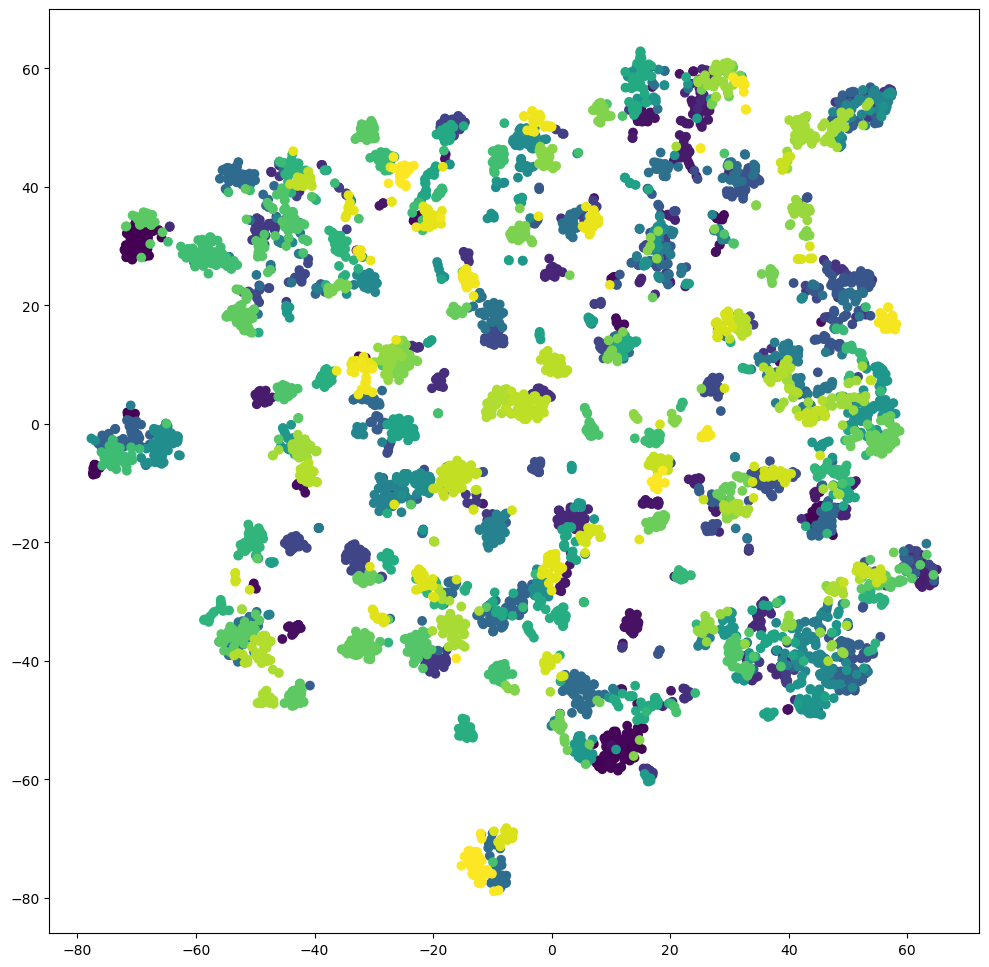

In [25]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_gnd.flatten());

10/10 [==============================] - 0s 12ms/step


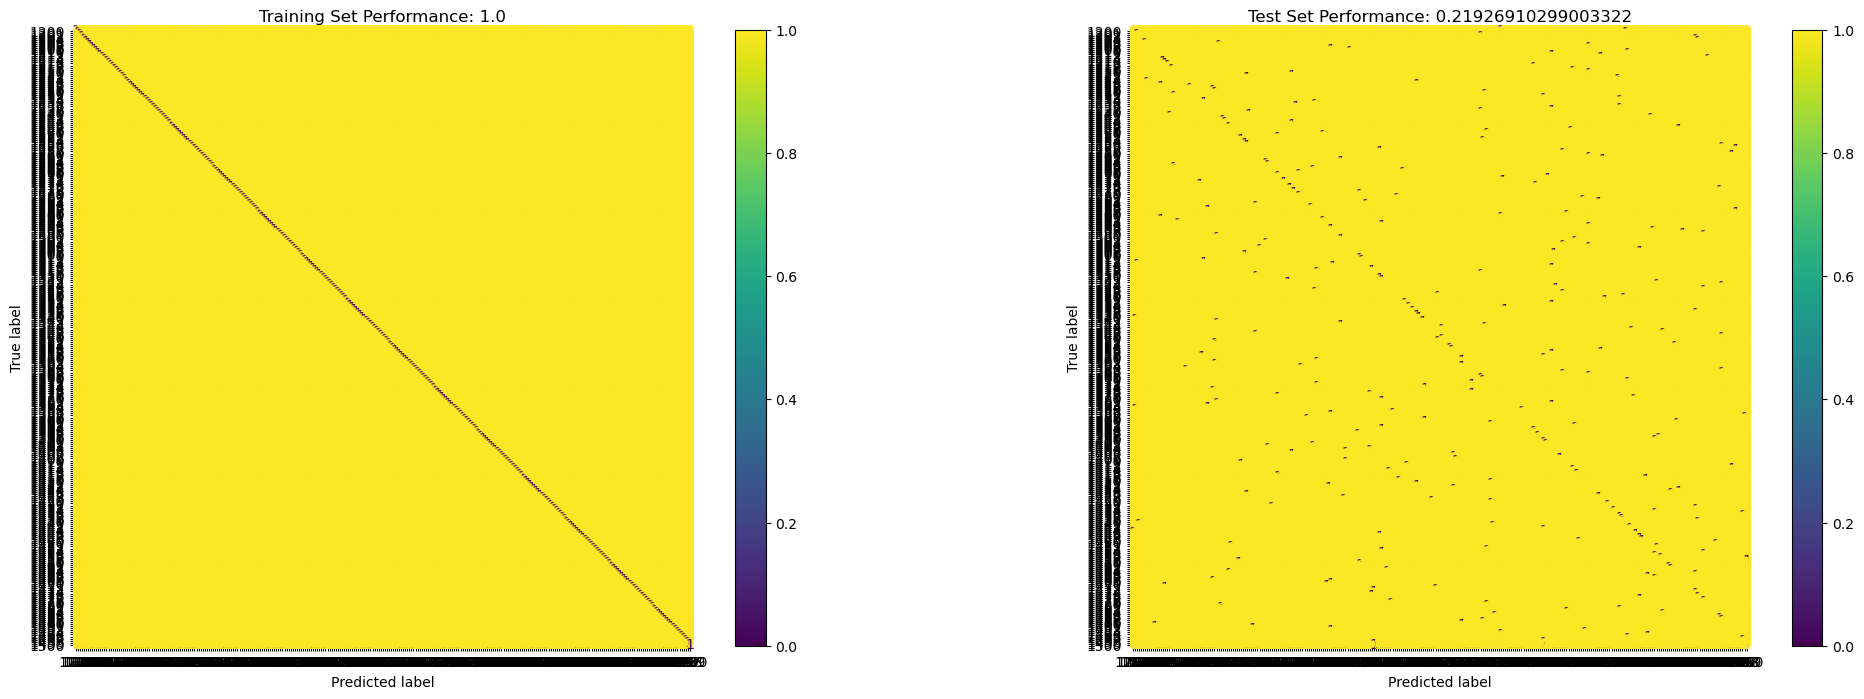

In [26]:
gallery_embeddings = base_network.predict(gallery_fea_reshape)
probe_embeddings = base_network.predict(probe_fea_reshape)
cknn_siam = KNeighborsClassifier(n_neighbors=3, weights='distance', n_jobs=-1)
cknn_siam.fit(gallery_embeddings, gallery_gnd)
eval_model(cknn_siam, gallery_embeddings, gallery_gnd, probe_embeddings, probe_gnd)

In [27]:
triplet_network.compile(optimizer=keras.optimizers.RMSprop(), metrics= [tf.keras.metrics.TopKCategoricalAccuracy(k=10)])

batch_size = 256
training_gen = triplet_generator(train_fea_reshape, train_gnd, batch_size)
triplet_test_x = get_triplet_data(gallery_fea_reshape, gallery_gnd, 1000)

triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=5, validation_data=(triplet_test_x, None))

Epoch 1/5
234/234 [==============================] - 133s 558ms/step - loss: 14.1650 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 0.6656 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/5
234/234 [==============================] - 133s 567ms/step - loss: 12.5256 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 0.5637 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 3/5
234/234 [==============================] - 132s 562ms/step - loss: 11.9150 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 0.5140 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 4/5
234/234 [==============================] - 135s 578ms/step - loss: 11.3259 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 0.5299 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 5/5
234/234 [==============================] - 137s 586ms/step - loss: 10.2750 - top_k_categorical_accuracy: 0.0000e+00 - val_loss: 0.4666 - val_top_k_categorical_accuracy: 0.0000e+00


186/186 [==============================] - 2s 12ms/step


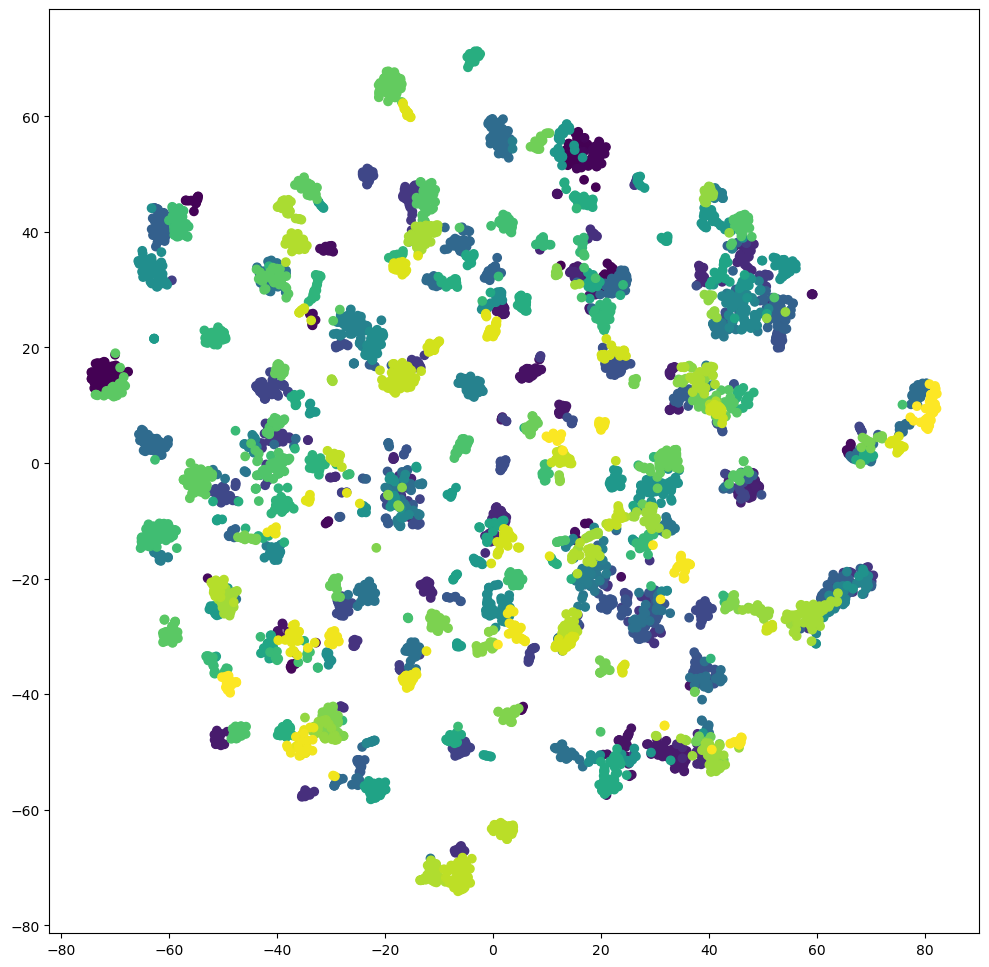

In [28]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_gnd.flatten());

10/10 [==============================] - 0s 12ms/step


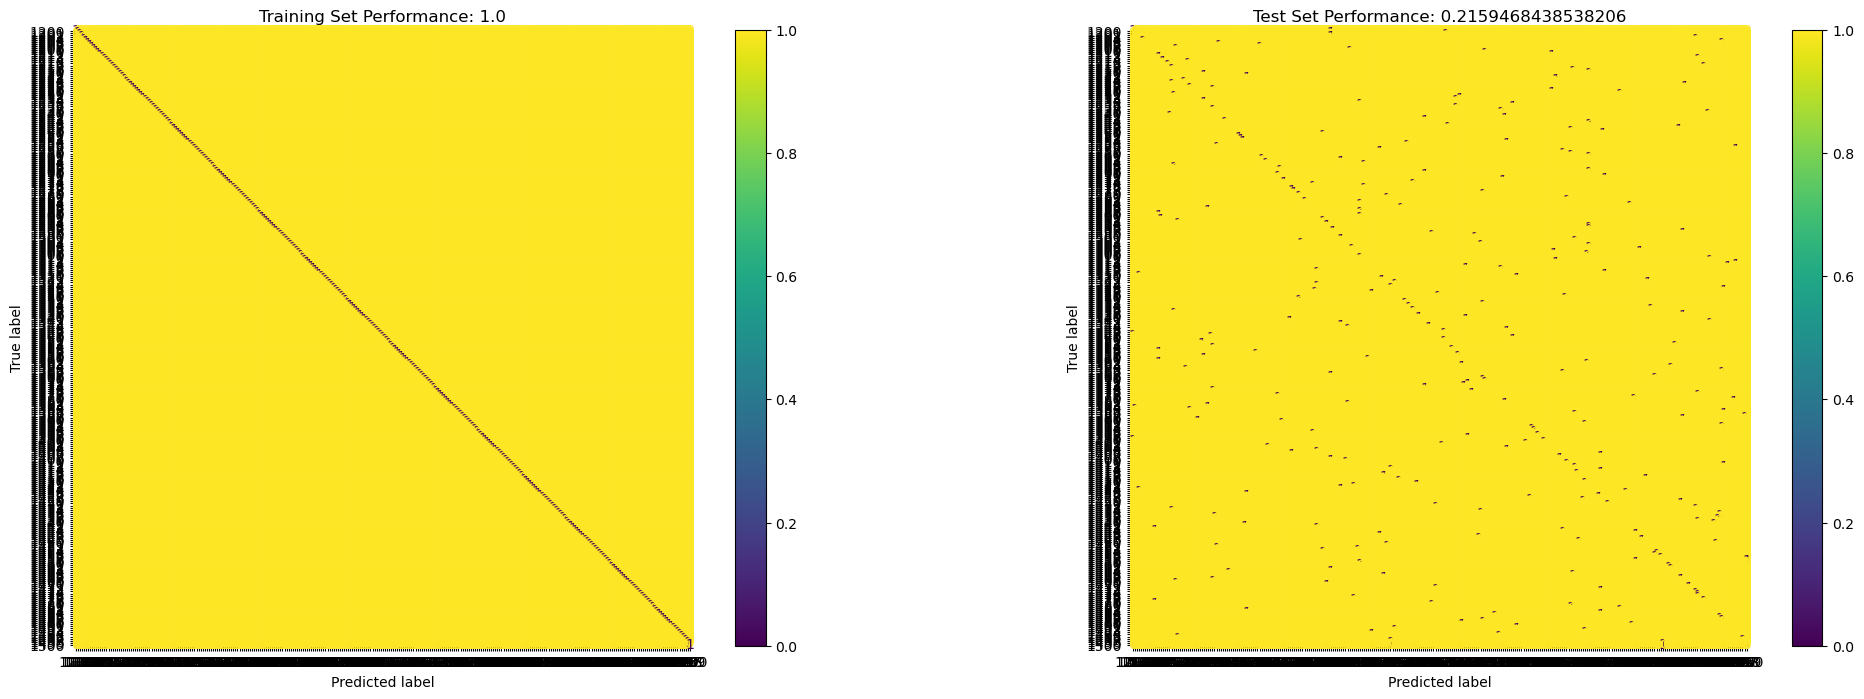

In [29]:
gallery_embeddings = base_network.predict(gallery_fea_reshape)
probe_embeddings = base_network.predict(probe_fea_reshape)
cknn_siam = KNeighborsClassifier(n_neighbors=3, weights='distance', n_jobs=-1)
cknn_siam.fit(gallery_embeddings, gallery_gnd)
eval_model(cknn_siam, gallery_embeddings, gallery_gnd, probe_embeddings, probe_gnd)